# Requesting Argo data from Ifremer erddap, standard mode

In standard mode, the Argo data fetcher library will perform post-processing to the data retrieved from the erddap. This post-processing is required to provide you with a currated collection of measurements directly usable for analysis, i.e. cleared from technical details of the Argo dataset.

List of post-processing:
- select appropriate fields for each variables (ie *adjusted* for D and A data modes).
- select measurements with good QC flags only (i.e. all variables with QC must 1 or 2).


***
Script prepared by [Guillaume Maze](http://github.com/gmaze) (Mar. 2020)

In [1]:
import sys, os
import numpy as np
import xarray as xr

try:
    import argopy
except ModuleNotFoundError:
    !pip install git+http://github.com/euroargodev/argopy.git@master
    import argopy
print("argopy:", argopy.__version__)
from argopy import DataFetcher as ArgoDataFetcher

# For plots:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

argopy: 0.1.1


# Create an Argo data loader

Let's create a data loader instance that will cache data locally for later re-use:

In [2]:
# argo_loader = ArgoDataFetcher(cachedir='tmp') # If you to save fetched data to limit data transfer usage
argo_loader = ArgoDataFetcher()
argo_loader

<datafetcher 'Not initialised'>
Backend: erddap
Fetchers: profile, float, region
User mode: standard

It is said ``Not initialised`` because we didn't specify yet what kind of data selection we want to perform.

It also specifies a user mode set to ``standard`` by default. See other notebooks for the ``expert`` mode.

# Example of data fetching for a specific region

To request data for a specific space/TIME region, you can use the ``region()`` method that requires a region definition as a list of at least 6 values: ``[lon_min, lon_max, lat_min, lat_max, pres_min, pres_max]``
 
You can otherwise with 8 values to specify a TIME period: ``[lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, date_min, date_max]``

## Zonal section, for a given year

In [3]:
box = [-80., 0., 26-0.5, 26+.5, 0, 1000, '2018-01-01','2018-12-31']
ds = argo_loader.region(box).to_xarray()
ds

<xarray.Dataset>
Dimensions:          (N_POINTS: 77737)
Coordinates:
    TIME             (N_POINTS) datetime64[ns] 2018-01-01T20:16:00 ... 2018-12-30T15:47:00
    LATITUDE         (N_POINTS) float64 26.08 26.08 26.08 ... 25.72 25.72 25.72
  * N_POINTS         (N_POINTS) int64 0 1 2 3 4 ... 84908 84909 84910 84911
    LONGITUDE        (N_POINTS) float64 -15.47 -15.47 -15.47 ... -63.1 -63.1
Data variables:
    CYCLE_NUMBER     (N_POINTS) int64 97 97 97 97 97 97 ... 236 236 236 236 236
    DATA_MODE        (N_POINTS) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION        (N_POINTS) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_POINTS) int64 6901620 6901620 ... 6901183 6901183
    POSITION_QC      (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES             (N_POINTS) float64 6.0 7.0 8.0 9.0 ... 975.2 985.1 993.2
    PRES_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PSAL             (N_POINTS) float64 36.81 36.81 36.81 ... 35.08 35.08 35.08
    PSAL_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP             (N_POINTS) float64 19.76 19.76 19.76 ... 6.986 6.888 6.792
    TEMP_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         http://www.ifremer.fr/erddap
    Fetched_by:           gmaze
    Fetched_date:         2020/04/06
    Fetched_constraints:  phy_[x=-80.00/0.00; y=25.50/26.50; z=0.0/1000.0; t=...
    Fetched_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.cs...
    history:              Variables filtered according to DATA_MODE; Variable...

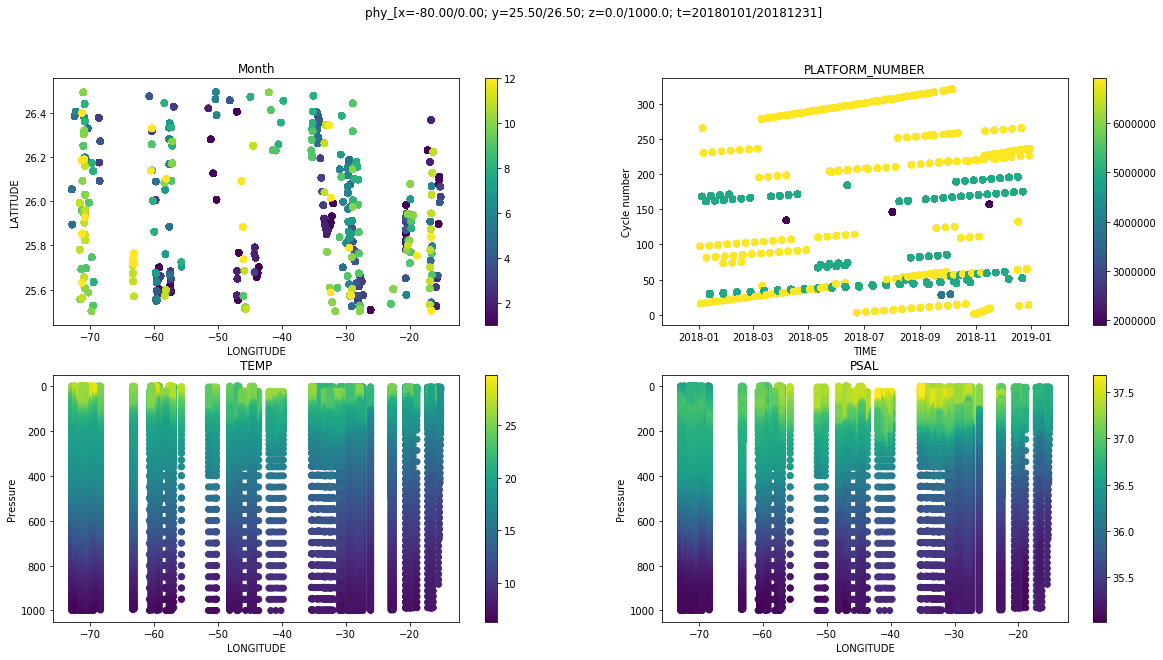

In [4]:
# Raw figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds['LONGITUDE'], ds['LATITUDE'], c=ds['TIME.month'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].set_xlabel('LONGITUDE')
ax[ix].set_ylabel('LATITUDE')
ax[ix].set_title('Month')

ix += 1
sc = ax[ix].scatter(ds['TIME'].values, ds['CYCLE_NUMBER'], c=ds['PLATFORM_NUMBER'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].set_xlabel('TIME')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('PLATFORM_NUMBER')

ix += 1
sc = ax[ix].scatter(ds['LONGITUDE'], ds['PRES'], c=ds['TEMP'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].invert_yaxis()
ax[ix].set_xlabel('LONGITUDE')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP')

ix += 1
sc = ax[ix].scatter(ds['LONGITUDE'], ds['PRES'], c=ds['PSAL'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].invert_yaxis()
ax[ix].set_xlabel('LONGITUDE')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL')

fig.suptitle(ds.attrs['Fetched_constraints']);

## Map of data around 200db depth for a single month

In [5]:
box = [-80., 0., 10., 65., 200-5., 200+5., '2018-01-01','2018-01-31']
ds = argo_loader.region(box).to_xarray()
ds

<xarray.Dataset>
Dimensions:          (N_POINTS: 4941)
Coordinates:
    TIME             (N_POINTS) datetime64[ns] 2018-01-01T00:12:23 ... 2018-01-30T23:14:00
    LATITUDE         (N_POINTS) float64 50.08 63.98 24.17 ... 45.64 64.26 64.26
  * N_POINTS         (N_POINTS) int64 0 1 3 4 5 6 ... 5341 5342 5343 5344 5345
    LONGITUDE        (N_POINTS) float64 -12.57 -55.93 -35.44 ... -30.72 -30.72
Data variables:
    CYCLE_NUMBER     (N_POINTS) int64 124 71 160 160 160 ... 97 40 131 134 134
    DATA_MODE        (N_POINTS) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'R' 'R'
    DIRECTION        (N_POINTS) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_POINTS) int64 6901920 6901721 ... 6901566 6901566
    POSITION_QC      (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES             (N_POINTS) float64 199.7 196.0 196.0 ... 200.3 195.0 205.0
    PRES_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PSAL             (N_POINTS) float64 35.51 34.82 36.66 ... 35.7 34.9 34.91
    PSAL_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP             (N_POINTS) float64 11.52 5.491 18.61 ... 13.29 5.19 5.234
    TEMP_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         http://www.ifremer.fr/erddap
    Fetched_by:           gmaze
    Fetched_date:         2020/04/06
    Fetched_constraints:  phy_[x=-80.00/0.00; y=10.00/65.00; z=195.0/205.0; t...
    Fetched_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.cs...
    history:              Variables filtered according to DATA_MODE; Variable...

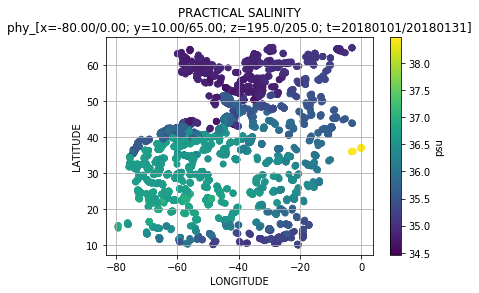

In [6]:
plt.scatter(ds['LONGITUDE'], ds['LATITUDE'], c=ds['PSAL'])
plt.colorbar(label=ds['PSAL'].attrs['units'])
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.gca().grid()
plt.title("%s\n%s" % (ds['PSAL'].attrs['long_name'], ds.attrs['Fetched_constraints']));

## Deployment over a region ?

In [7]:
# Retrieve all data for a region near the surface and a single month:
box = [-80., -45, 10, 45, 0, 10, '2018-01-01','2018-12-31']
ds = argo_loader.region(box).to_xarray()

# Then select only the first cycle number:
this = ds.where(ds['CYCLE_NUMBER']==1, drop=True).drop_vars('CYCLE_NUMBER')

# And group by WMOs:
this = this.reset_coords().groupby('PLATFORM_NUMBER').min()
this

<xarray.Dataset>
Dimensions:          (PLATFORM_NUMBER: 29)
Coordinates:
  * PLATFORM_NUMBER  (PLATFORM_NUMBER) float64 3.902e+06 3.902e+06 ... 6.901e+06
Data variables:
    DATA_MODE        (PLATFORM_NUMBER) object 'D' 'D' 'D' 'D' ... 'D' 'D' 'A'
    DIRECTION        (PLATFORM_NUMBER) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    POSITION_QC      (PLATFORM_NUMBER) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    PRES             (PLATFORM_NUMBER) float64 6.0 6.0 6.0 6.0 ... 1.0 0.96 4.3
    PRES_QC          (PLATFORM_NUMBER) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    PSAL             (PLATFORM_NUMBER) float64 36.52 36.76 36.9 ... 36.53 37.48
    PSAL_QC          (PLATFORM_NUMBER) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    TEMP             (PLATFORM_NUMBER) float64 20.14 21.72 21.6 ... 24.13 26.19
    TEMP_QC          (PLATFORM_NUMBER) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    TIME_QC          (PLATFORM_NUMBER) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    TIME             (PLATFORM_NUMBER) datetime64[ns] 2018-04-17T05:47:00 ... 2018-11-07T12:04:51
    LATITUDE         (PLATFORM_NUMBER) float64 34.0 32.4 32.99 ... 35.4 24.13
    LONGITUDE        (PLATFORM_NUMBER) float64 -54.97 -60.11 ... -73.67 -49.03

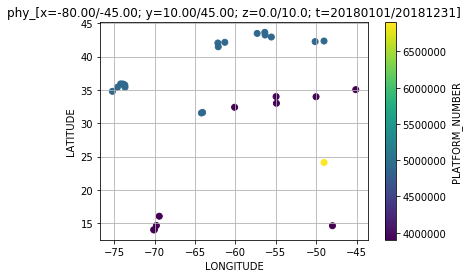

In [8]:
plt.scatter(this['LONGITUDE'], this['LATITUDE'], c=this['PLATFORM_NUMBER'])
plt.colorbar(label='PLATFORM_NUMBER')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.gca().grid()
plt.title("%s" % ds.attrs['Fetched_constraints']);

# Example of data fetching for a specific float

In [9]:
ds = argo_loader.float(6902746).to_xarray()
ds

<xarray.Dataset>
Dimensions:          (N_POINTS: 9039)
Coordinates:
    TIME             (N_POINTS) datetime64[ns] 2017-07-06T14:49:00 ... 2019-02-13T07:20:00
    LATITUDE         (N_POINTS) float64 20.08 20.08 20.08 ... 16.3 16.3 16.3
  * N_POINTS         (N_POINTS) int64 0 1 2 3 4 5 ... 9034 9035 9036 9037 9038
    LONGITUDE        (N_POINTS) float64 -60.17 -60.17 -60.17 ... -62.64 -62.64
Data variables:
    CYCLE_NUMBER     (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 84 84 84 84 84 84 84
    DATA_MODE        (N_POINTS) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION        (N_POINTS) <U1 'D' 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_POINTS) int64 6902746 6902746 ... 6902746 6902746
    POSITION_QC      (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES             (N_POINTS) float64 9.0 14.0 24.0 ... 1.488e+03 1.509e+03
    PRES_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PSAL             (N_POINTS) float64 36.06 36.06 36.06 ... 34.98 34.98 34.98
    PSAL_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2
    TEMP             (N_POINTS) float64 28.04 28.03 28.02 ... 4.286 4.281 4.277
    TEMP_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         http://www.ifremer.fr/erddap
    Fetched_by:           gmaze
    Fetched_date:         2020/04/06
    Fetched_constraints:  phy_WMO6902746
    Fetched_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.cs...
    history:              Variables filtered according to DATA_MODE; Variable...

In [10]:
# Get basic information about the float:
print('This float has performed: %i profiles' % len(np.unique(ds['CYCLE_NUMBER'])))
print('This float operated between %s and %s' % (ds['TIME'].min().values, ds['TIME'].max().values))
print('This float profiles range from %0.1fdb to %0.1fdb' % (ds['PRES'].min(), ds['PRES'].max() ))

This float has performed: 84 profiles
This float operated between 2017-07-06T14:49:00.000000000 and 2019-02-13T07:20:00.000000000
This float profiles range from 3.0db to 2032.0db


In [11]:
ds.argo.point2profile()

<xarray.Dataset>
Dimensions:          (N_LEVELS: 110, N_PROF: 85)
Coordinates:
    LATITUDE         (N_PROF) float64 20.08 20.13 20.21 ... 15.06 15.93 16.3
    TIME             (N_PROF) datetime64[ns] 2017-07-06T14:49:00 ... 2019-02-13T07:20:00
  * N_LEVELS         (N_LEVELS) int64 0 1 2 3 4 5 6 ... 104 105 106 107 108 109
  * N_PROF           (N_PROF) int64 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
    LONGITUDE        (N_PROF) float64 -60.17 -60.14 -59.99 ... -62.54 -62.64
Data variables:
    CYCLE_NUMBER     (N_PROF) int64 1 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
    DATA_MODE        (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION        (N_PROF) <U1 'D' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) int64 6902746 6902746 6902746 ... 6902746 6902746
    POSITION_QC      (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PRES             (N_PROF, N_LEVELS) float64 9.0 14.0 24.0 ... nan nan nan
    PRES_QC          (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PSAL             (N_PROF, N_LEVELS) float64 36.06 36.06 36.06 ... nan nan
    PSAL_QC          (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2
    TEMP             (N_PROF, N_LEVELS) float64 28.04 28.03 28.02 ... nan nan
    TEMP_QC          (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    TIME_QC          (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         http://www.ifremer.fr/erddap
    Fetched_by:           gmaze
    Fetched_date:         2020/04/06
    Fetched_constraints:  phy_WMO6902746
    Fetched_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.cs...
    history:              Variables filtered according to DATA_MODE; Variable...

## Plot trajectory

Text(0.5, 1.0, 'phy_WMO6902746')

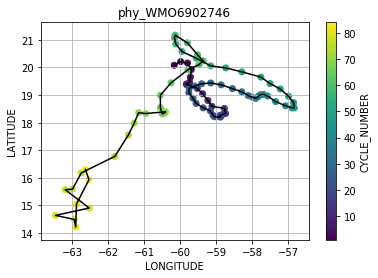

In [12]:
this = ds.reset_coords().groupby('CYCLE_NUMBER').min()
plt.plot(this['LONGITUDE'], this['LATITUDE'], 'k-')
plt.scatter(this['LONGITUDE'], this['LATITUDE'], c=this['CYCLE_NUMBER'])
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.gca().grid()
plt.colorbar(label='CYCLE_NUMBER')
plt.title(ds.attrs['Fetched_constraints'])

## Time/Depth plots

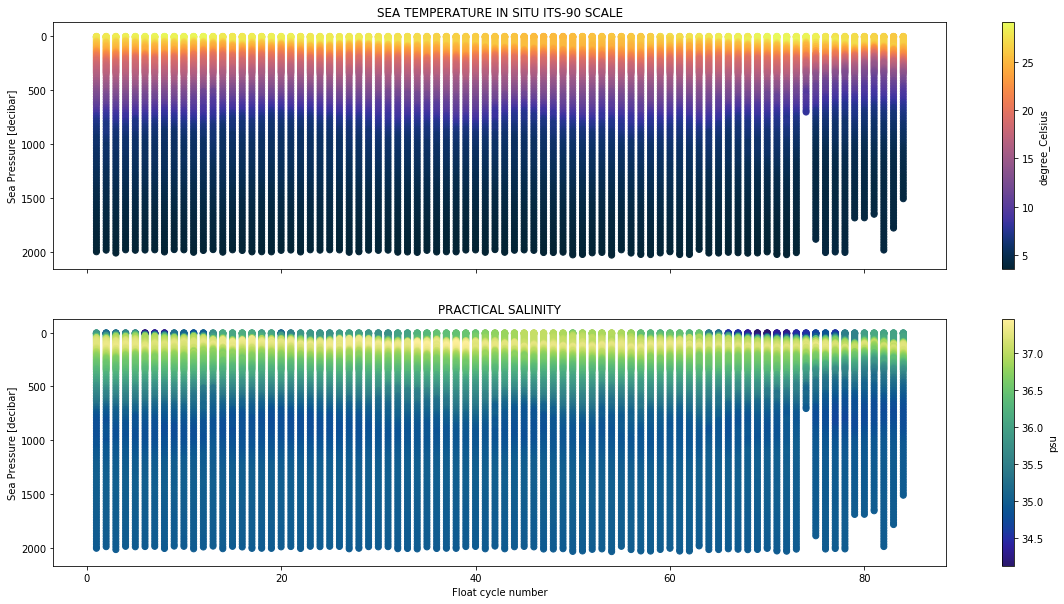

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=ds['TEMP'].attrs['units'])
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=ds['PSAL'].attrs['units'])
# ax[ix].invert_yaxis()
ax[ix].set_xlabel(ds['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['PSAL'].attrs['long_name']);


## Super-imposed profiles

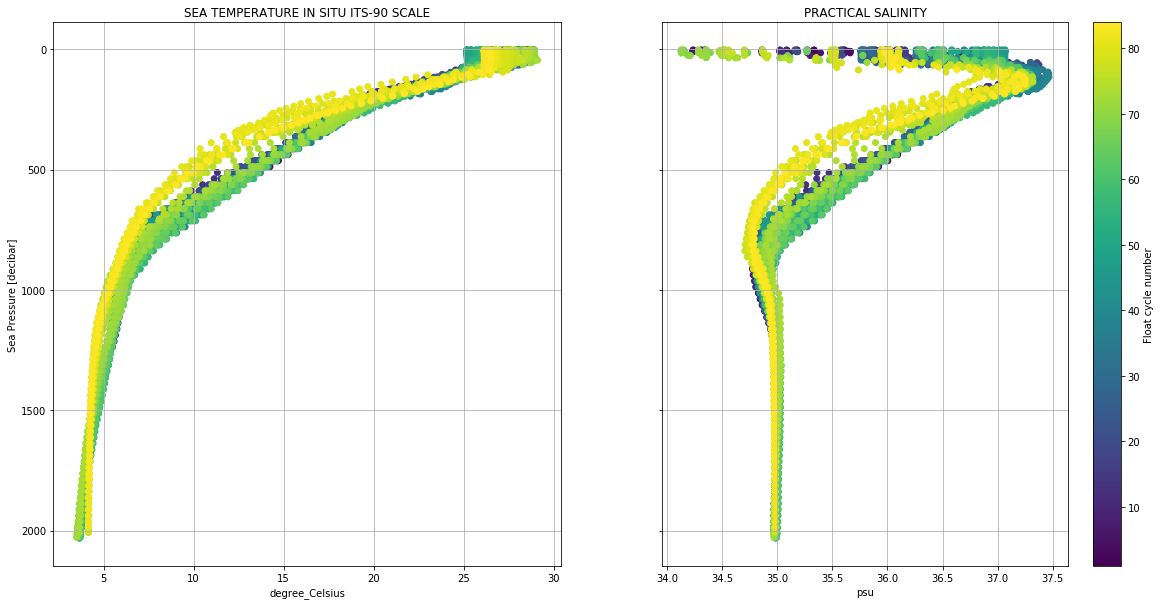

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds['TEMP'], ds['PRES'], c=ds['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(ds['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(ds['PSAL'], ds['PRES'], c=ds['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[ix], label=ds['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].grid()
ax[ix].set_xlabel(ds['PSAL'].attrs['units'])
ax[ix].set_title(ds['PSAL'].attrs['long_name']);


## T/S diagram

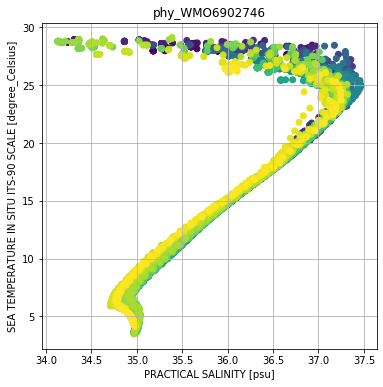

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax = np.array(ax).flatten()
ix = 0
sc = ax[ix].scatter(ds['PSAL'], ds['TEMP'], c=ds['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].set_xlabel("%s [%s]" % (ds['PSAL'].attrs['long_name'], ds['PSAL'].attrs['units']))
ax[ix].set_ylabel("%s [%s]" % (ds['TEMP'].attrs['long_name'], ds['TEMP'].attrs['units']))
plt.title(ds.attrs['Fetched_constraints']);

# Example of data fetching for a specific profile

In [16]:
ds = argo_loader.profile(6902746, 12).to_xarray()
ds

<xarray.Dataset>
Dimensions:          (N_POINTS: 108)
Coordinates:
    TIME             (N_POINTS) datetime64[ns] 2017-09-01T06:53:00 ... 2017-09-01T06:53:00
    LATITUDE         (N_POINTS) float64 18.8 18.8 18.8 18.8 ... 18.8 18.8 18.8
  * N_POINTS         (N_POINTS) int64 0 1 2 3 4 5 6 ... 102 103 104 105 106 107
    LONGITUDE        (N_POINTS) float64 -59.24 -59.24 -59.24 ... -59.24 -59.24
Data variables:
    CYCLE_NUMBER     (N_POINTS) int64 12 12 12 12 12 12 12 ... 12 12 12 12 12 12
    DATA_MODE        (N_POINTS) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION        (N_POINTS) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_POINTS) int64 6902746 6902746 ... 6902746 6902746
    POSITION_QC      (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES             (N_POINTS) float64 3.0 4.0 5.0 ... 1.963e+03 1.989e+03
    PRES_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PSAL             (N_POINTS) float64 35.02 35.03 35.03 ... 34.99 34.99 34.99
    PSAL_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP             (N_POINTS) float64 28.9 28.9 28.9 ... 3.771 3.734 3.693
    TEMP_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         http://www.ifremer.fr/erddap
    Fetched_by:           gmaze
    Fetched_date:         2020/04/06
    Fetched_constraints:  phy_WMO6902746_CYC0012
    Fetched_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.cs...
    history:              Variables filtered according to DATA_MODE; Variable...

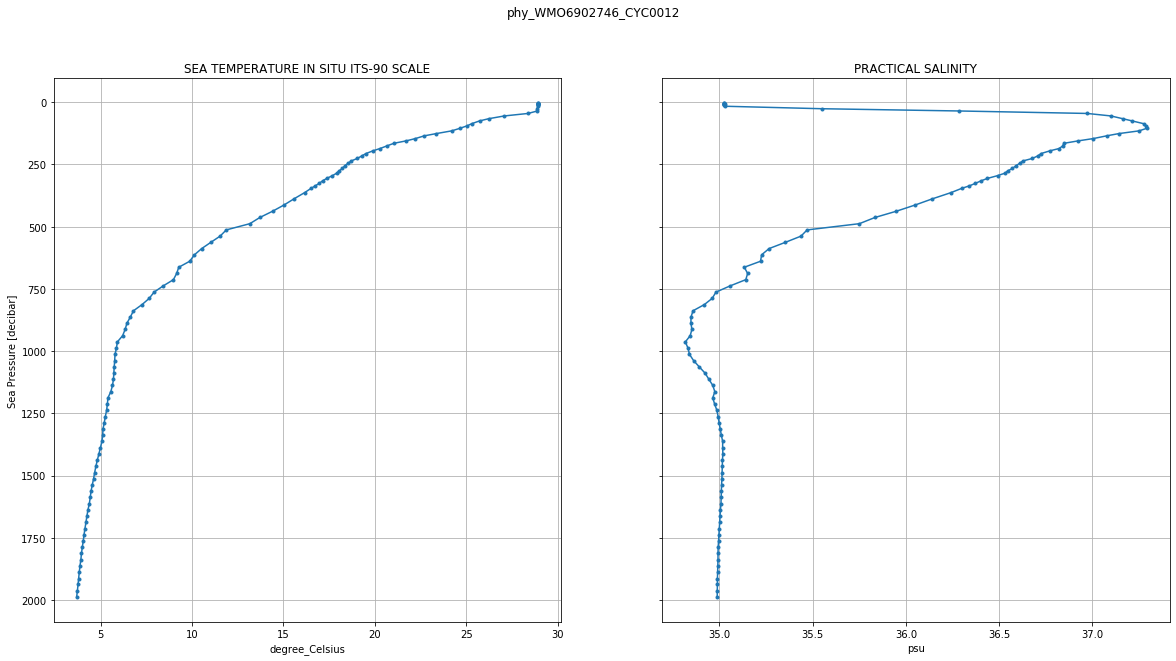

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
ax[ix].plot(ds['TEMP'], ds['PRES'], '.-')
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(ds['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['TEMP'].attrs['long_name'])

ix += 1
ax[ix].plot(ds['PSAL'], ds['PRES'], '.-')
ax[ix].grid()
ax[ix].set_xlabel(ds['PSAL'].attrs['units'])
ax[ix].set_title(ds['PSAL'].attrs['long_name']);

fig.suptitle(ds.attrs['Fetched_constraints']);

***
This work is part and was supported by the following projects:
<div>
<img src="https://avatars1.githubusercontent.com/u/58258213?s=460&v=4" width="70"/>
<img src="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>